In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r2, r3, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [5]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    '/home/hj/Code/Playground/cvProject/kul-computer-vision-ga-1-2025/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '/home/hj/Code/Playground/cvProject/kul-computer-vision-ga-1-2025/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('/home/hj/Code/Playground/cvProject/kul-computer-vision-ga-1-2025/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('/home/hj/Code/Playground/cvProject/kul-computer-vision-ga-1-2025/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [6]:
# The training set contains an identifier, name, image information and class label
train.head(1)

name  class                                                img
id                                                                      
0   Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...

In [7]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [8]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [9]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [10]:
# parameter to play with 
FACE_SIZE = (100, 100)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)



/tmp/ipykernel_346766/4005177570.py:53: RuntimeWarning: invalid value encountered in cast
  return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)


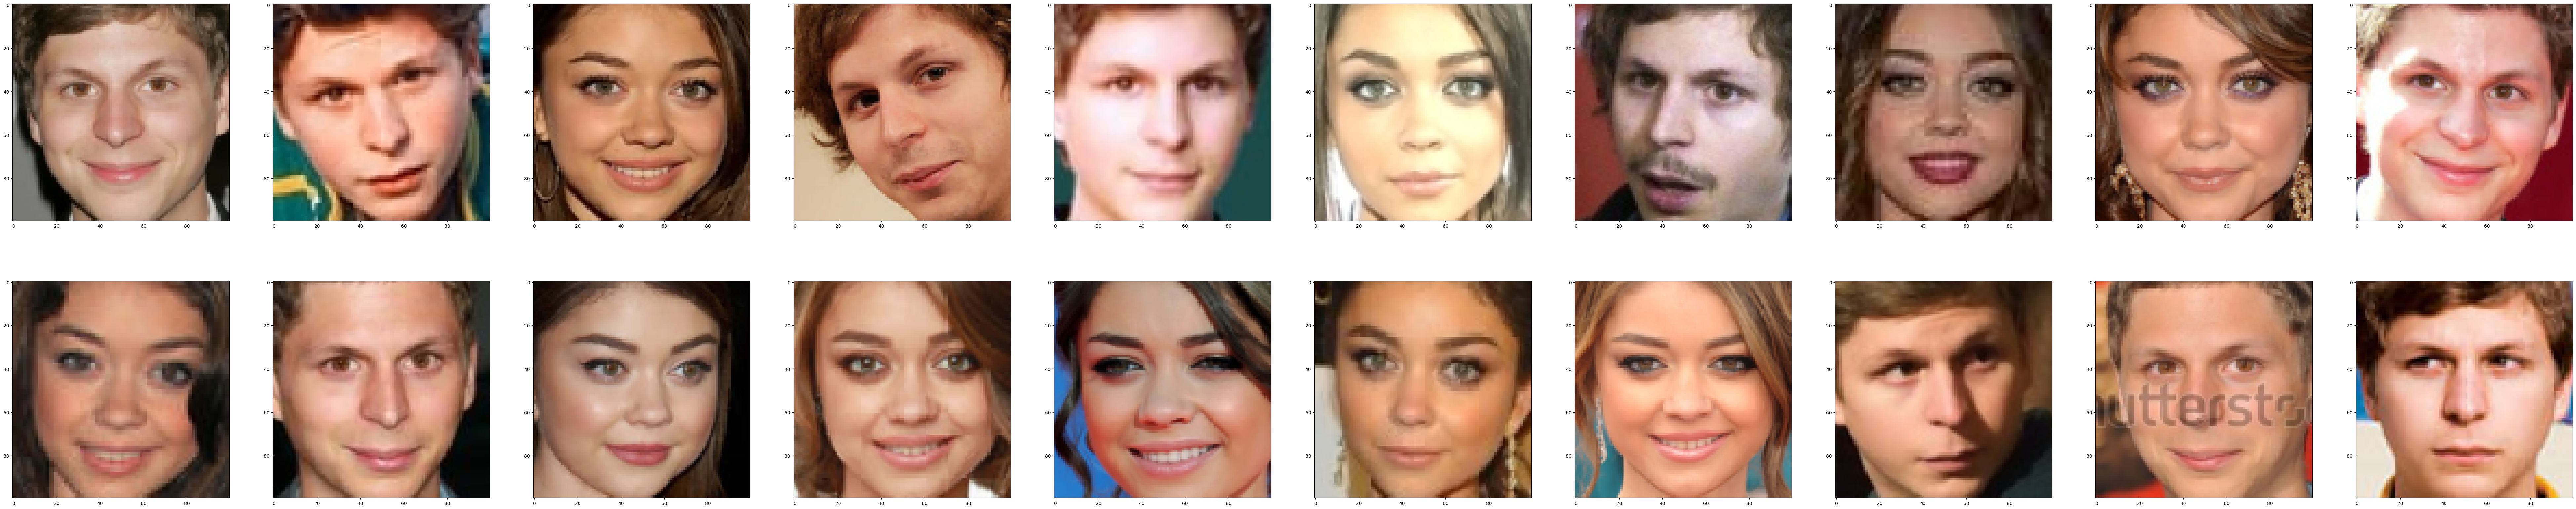

In [11]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9223372036854775808..-9223372036854775808].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9223372036854775808..-9223372036854775808].


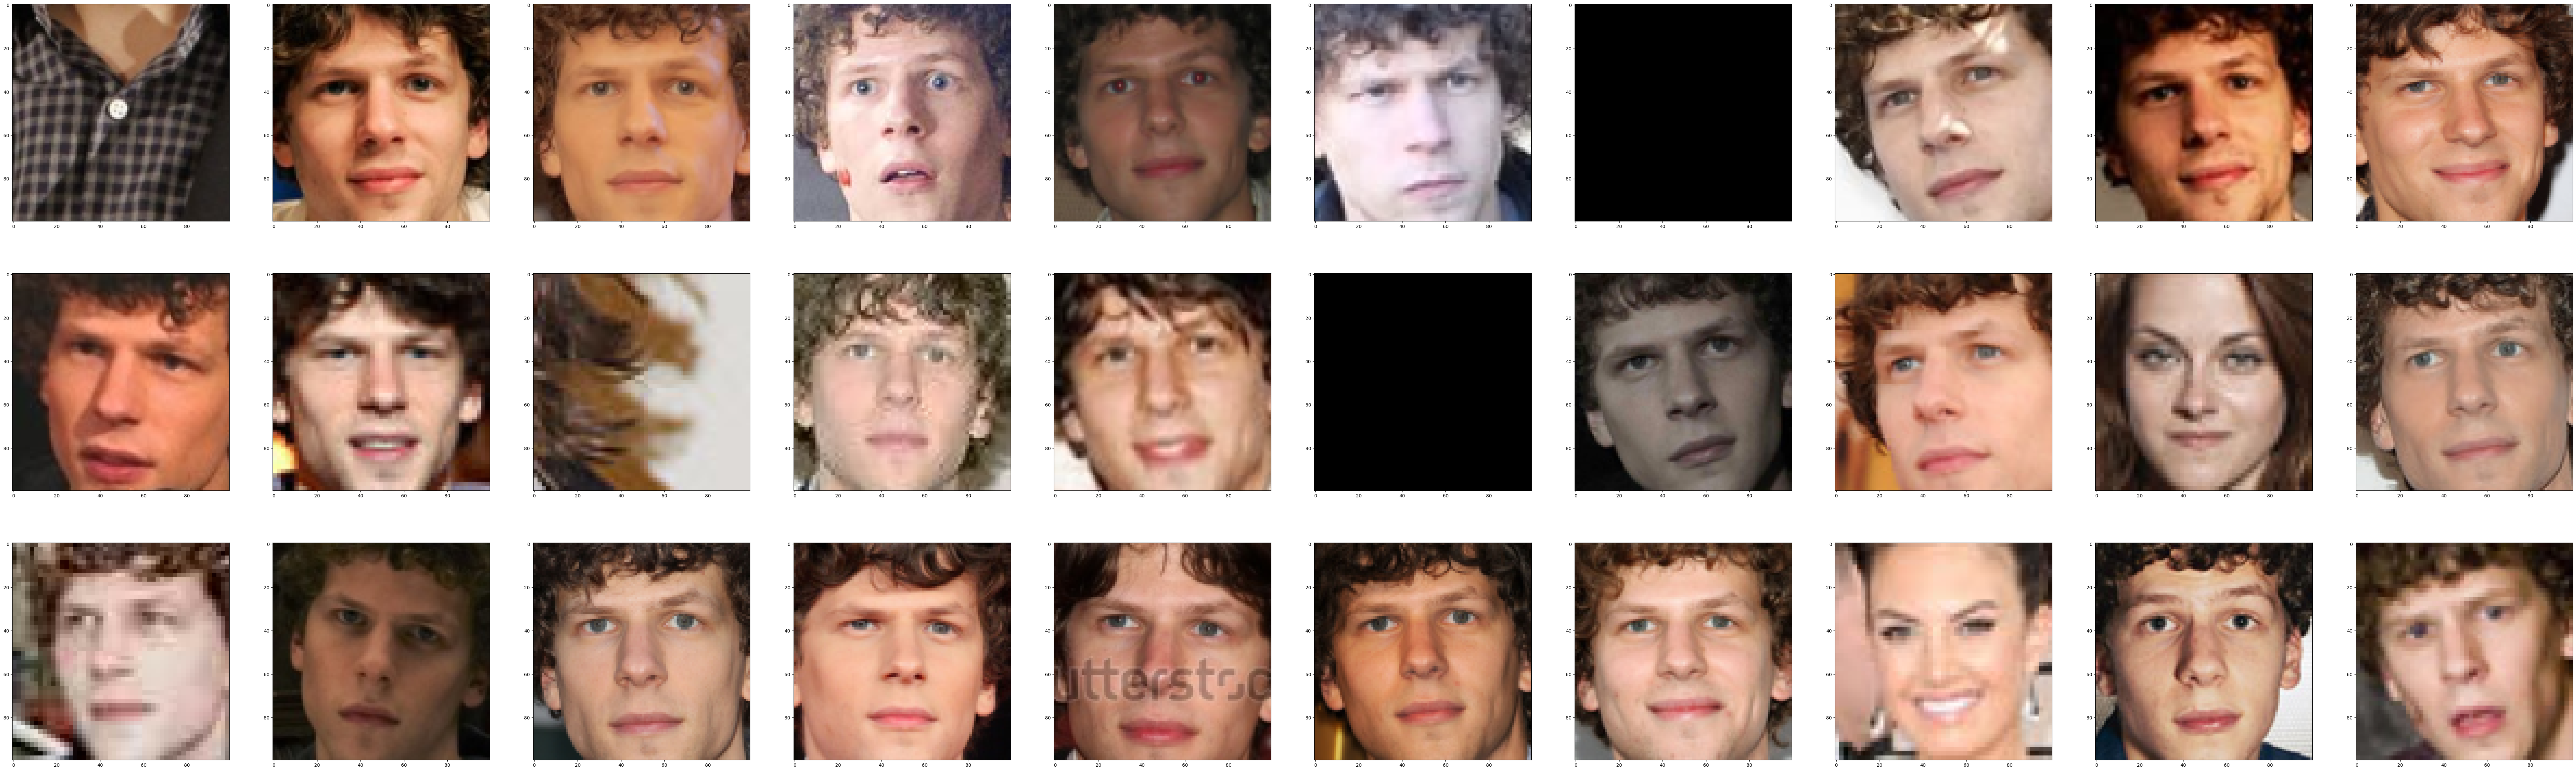

In [12]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9223372036854775808..-9223372036854775808].


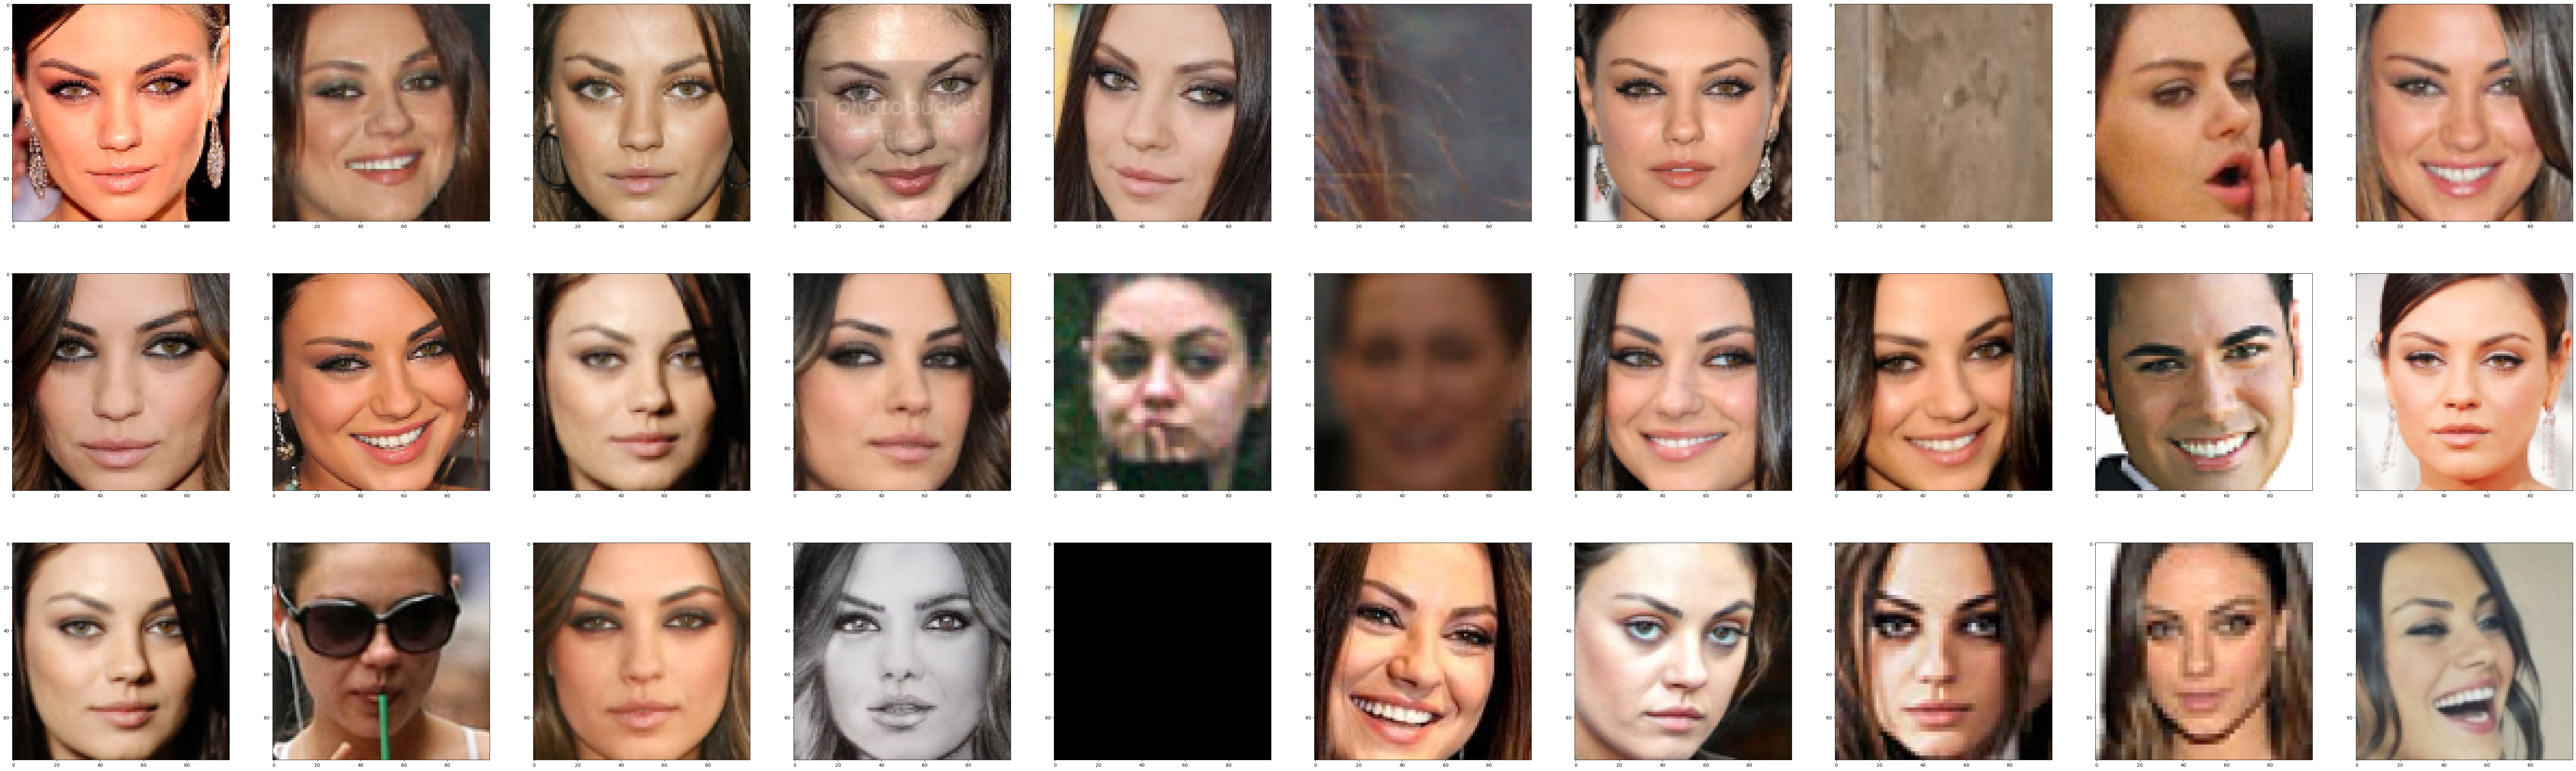

In [13]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [15]:
# save preprocessed data
prep_path = '/home/hj/Code/Playground/cvProject/prepped_data/'
if not os.path.exists(prep_path):
    os.mkdir(prep_path)
    
np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
prep_path = '/home/hj/Code/Playground/cvProject/prepped_data/'
if not os.path.exists(prep_path):
    os.mkdir(prep_path)
train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [16]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
...

In [17]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(**params):
        self.params = params
        
    def transform(self, X):
        raise NotImplmentedError

### 1.1.1. t-SNE Plots
...

### 1.1.2. Discussion
...

## 1.2. Baseline 2: PCA feature extractor
...

In [42]:
class PCAFeatureExtractor:
    """
    Principal Component Analysis (PCA) feature extractor for face recognition (Eigenfaces).

    This class implements the eigenfaces approach, which uses PCA to find the
    principal components of a distribution of faces, then projects face images
    onto a feature space that spans the significant variations among known face images.

    Parameters:
    -----------
    n_components : int, optional (default=None)
        Number of components to keep. If None, all components are kept.

    whiten : bool, optional (default=False)
        When True, the components are divided by the singular values to ensure
        uncorrelated outputs with unit component-wise variances.
    """

    def __init__(self, n_components=None, whiten=False):
        self.n_components = n_components
        self.whiten = whiten
        self.pca = None
        self.mean_face = None
        self.original_shape = None

    def fit(self, X):
        """
        Fit the PCA model with the face images.

        Parameters:
        -----------
        X : numpy array
            Array of face images (flattened or in their original shape)

        Returns:
        --------
        self : object
            Returns self.
        """
        if len(X.shape) > 2:
            self.original_shape = X.shape[1:]
            X_flat = X.reshape(X.shape[0], -1)
        else:
            self.original_shape = None
            X_flat = X

        from sklearn.decomposition import PCA

        self.pca = PCA(n_components=self.n_components, whiten=self.whiten)
        self.pca.fit(X_flat)

        self.mean_face = self.pca.mean_

        return self

    def transform(self, X):
        """
        Project images onto the eigenface space.
        
        Parameters:
        -----------
        X : numpy array
            Array of images to transform.
            
        Returns:
        --------
        X_transformed : numpy array
            Transformed image data (eigenface coefficients).
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")
        
        # Flatten the images if needed
        if len(X.shape) > 2:
            X_flat = X.reshape(X.shape[0], -1)
        else:
            X_flat = X
        
        # Apply PCA transformation
        projections = self.pca.transform(X_flat)
        
        # Apply scaling if needed - normalize the projections if they have extreme values
        if np.abs(projections).max() > 1e10:
            projections = projections / np.abs(projections).max()  # Simple normalization
        
        return projections

    def inverse_transform(self, X_transformed):
        """
        Transform data back to its original space (reconstruct images).

        Parameters:
        -----------
        X_transformed : numpy array
            Eigenface coefficients.

        Returns:
        --------
        X_reconstructed : numpy array
            Array of reconstructed images.
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")

        X_reconstructed = self.pca.inverse_transform(X_transformed)

        if self.original_shape is not None:
            X_reconstructed = X_reconstructed.reshape(-1, *self.original_shape)

        return X_reconstructed

    def get_eigenfaces(self):
        """
        Get the eigenfaces (principal components).

        Returns:
        --------
        eigenfaces : numpy array
            Array of eigenfaces with original image shape if available.
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")

        eigenfaces = self.pca.components_

        # Reshape eigenfaces to original image shape if available
        if self.original_shape is not None:
            eigenfaces = eigenfaces.reshape(-1, *self.original_shape)

        return eigenfaces

    def get_mean_face(self):
        """
        Get the mean face.

        Returns:
        --------
        mean_face : numpy array
            Mean face with original image shape if available.
        """
        if self.mean_face is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")

        mean_face = self.mean_face.copy()

        if self.original_shape is not None:
            mean_face = mean_face.reshape(self.original_shape)

        return mean_face

    def find_optimal_components(self, variance_threshold=0.95):
        """
        Find the optimal number of components to retain a given percentage of variance.

        Parameters:
        -----------
        variance_threshold : float, optional (default=0.95)
            Percentage of variance to retain (between 0 and 1).

        Returns:
        --------
        n_components : int
            Optimal number of components.
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")

        cumulative_variance = np.cumsum(self.pca.explained_variance_ratio_)
        return np.argmax(cumulative_variance >= variance_threshold) + 1

    def plot_explained_variance(self, figsize=(10, 6)):
        """
        Plot the explained variance ratio and cumulative explained variance.

        Parameters:
        -----------
        figsize : tuple, optional (default=(10, 6))
            Size of the figure.
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")

        _, ax = plt.subplots(figsize=figsize)

        ax.bar(
            range(1, len(self.pca.explained_variance_ratio_) + 1),
            self.pca.explained_variance_ratio_,
            alpha=0.5,
            label="Individual explained variance",
        )

        ax.step(
            range(1, len(self.pca.explained_variance_ratio_) + 1),
            np.cumsum(self.pca.explained_variance_ratio_),
            where="mid",
            label="Cumulative explained variance",
        )

        ax.set_xlabel("Number of Principal Components")
        ax.set_ylabel("Explained Variance Ratio")
        ax.set_title("Explained Variance by Principal Components")
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

    def plot_eigenfaces(self, n_eigenfaces=16, figsize=(12, 12)):
        """
        Plot the first n_eigenfaces.

        Parameters:
        -----------
        n_eigenfaces : int, optional (default=16)
            Number of eigenfaces to plot.
        figsize : tuple, optional (default=(12, 12))
            Size of the figure.
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")

        eigenfaces = self.get_eigenfaces()
        n_eigenfaces = min(n_eigenfaces, len(eigenfaces))

        n_cols = int(np.ceil(np.sqrt(n_eigenfaces)))
        n_rows = int(np.ceil(n_eigenfaces / n_cols))

        _, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()

        for i in range(n_eigenfaces):
            eigenface = eigenfaces[i]

            if eigenface.ndim == 3:
                normalized = np.zeros_like(eigenface, dtype=np.float64)
                for c in range(eigenface.shape[2]):
                    channel = eigenface[..., c]
                    normalized[..., c] = (channel - channel.min()) / (
                        channel.max() - channel.min() + 1e-10
                    )
                eigenface = normalized
            else:
                eigenface = (eigenface - eigenface.min()) / (
                    eigenface.max() - eigenface.min() + 1e-10
                )

            if eigenface.ndim == 3 and eigenface.shape[2] == 3:
                axes[i].imshow(eigenface)
            else:
                axes[i].imshow(eigenface, cmap="gray")

            axes[i].set_title(f"Eigenface {i+1}")
            axes[i].axis("off")

        for i in range(n_eigenfaces, len(axes)):
            axes[i].axis("off")

        plt.suptitle("Eigenfaces", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

    def plot_face_reconstruction(self, face, components_range, figsize=(15, 8)):
        """
        Plot the reconstruction of a face using different numbers of components.
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")
        
        # Flatten the face if needed
        if len(face.shape) > 1 and self.original_shape is not None:
            face_flat = face.reshape(1, -1)
        else:
            face_flat = face.reshape(1, -1)
        
        # Project face onto eigenface space
        coeffs = self.pca.transform(face_flat)
        
        n_images = len(components_range) + 1  # Original + reconstructions
        n_cols = min(4, n_images)
        n_rows = int(np.ceil(n_images / n_cols))
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        if n_rows * n_cols == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        # Plot original face
        original_face = face
        if len(original_face.shape) > 1 and self.original_shape is not None:
            original_face = original_face.reshape(self.original_shape)
                
        if original_face.ndim == 3 and original_face.shape[2] == 3:  # RGB image
            axes[0].imshow(original_face.astype(np.uint8))
        else:  # Grayscale image
            axes[0].imshow(original_face, cmap='gray')
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        # Plot reconstructions
        for i, n_comp in enumerate(components_range):
            # Copy coefficients and zero out beyond n_comp
            coeffs_limited = coeffs.copy()
            coeffs_limited[0, n_comp:] = 0
            
            # Reconstruct face
            reconstructed = self.pca.inverse_transform(coeffs_limited)
            
            # Reshape if needed
            if self.original_shape is not None:
                reconstructed = reconstructed.reshape(self.original_shape)
            
            # Normalize the reconstructed image for display
            if reconstructed.ndim == 3:  # Color image
                # Normalize each channel separately
                reconstructed_norm = np.zeros_like(reconstructed, dtype=np.float64)
                for c in range(reconstructed.shape[2]):
                    channel = reconstructed[..., c]
                    min_val = np.min(channel)
                    max_val = np.max(channel)
                    if max_val > min_val:
                        reconstructed_norm[..., c] = (channel - min_val) / (max_val - min_val)
                reconstructed = (reconstructed_norm * 255).astype(np.uint8)
            else:  # Grayscale
                min_val = np.min(reconstructed)
                max_val = np.max(reconstructed)
                if max_val > min_val:
                    reconstructed = (reconstructed - min_val) / (max_val - min_val)
            
            if reconstructed.ndim == 3 and reconstructed.shape[2] == 3:  # RGB image
                axes[i+1].imshow(reconstructed)
            else:  # Grayscale image
                axes[i+1].imshow(reconstructed, cmap='gray')
            
            axes[i+1].set_title(f"{n_comp} components")
            axes[i+1].axis('off')
        
        # Hide unused subplots
        for i in range(n_images, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle("Face Reconstruction with Different Numbers of Components", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
        
    def plot_feature_space(self, X, labels, figsize=(10, 8)):
        """
        Plot the data points in the first two principal components space.

        Parameters:
        -----------
        X : numpy array
            Array of images.
        labels : numpy array
            Labels for the images.
        figsize : tuple, optional (default=(10, 8))
            Size of the figure.
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")

        projections = self.transform(X)

        unique_labels = np.unique(labels)
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

        plt.figure(figsize=figsize)
        for i, label in enumerate(unique_labels):
            mask = labels == label
            plt.scatter(
                projections[mask, 0],
                projections[mask, 1],
                color=colors[i],
                label=f"Class {label}",
                alpha=0.7,
            )

        plt.xlabel("First Principal Component")
        plt.ylabel("Second Principal Component")
        plt.title("Face Images Projected onto the First Two Principal Components")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def calculate_reconstruction_error(self, X, n_components):
        """
        Calculate the mean squared reconstruction error using n_components.

        Parameters:
        -----------
        X : numpy array
            Array of images.
        n_components : int
            Number of components to use for reconstruction.

        Returns:
        --------
        error : float
            Mean squared reconstruction error.
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")

        if len(X.shape) > 2:
            X_flat = X.reshape(X.shape[0], -1)
        else:
            X_flat = X

        projections = self.pca.transform(X_flat)

        projections_limited = projections.copy()
        projections_limited[:, n_components:] = 0

        reconstructed = self.pca.inverse_transform(projections_limited)

        mse = np.mean((X_flat - reconstructed) ** 2)
        return mse

### 1.2.1. Eigenface Plots
...

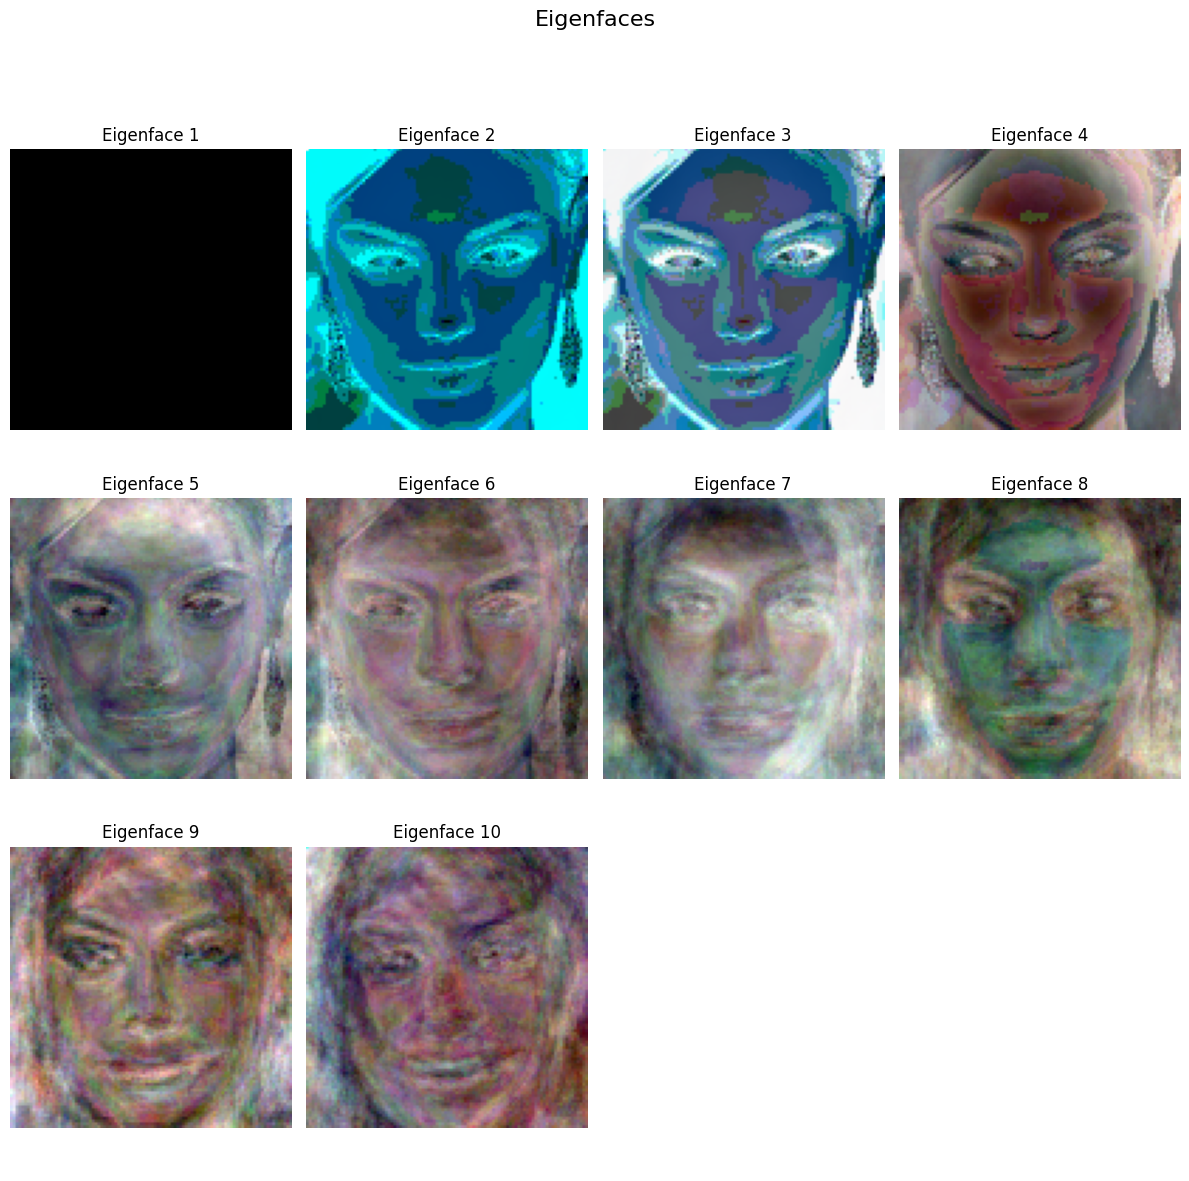

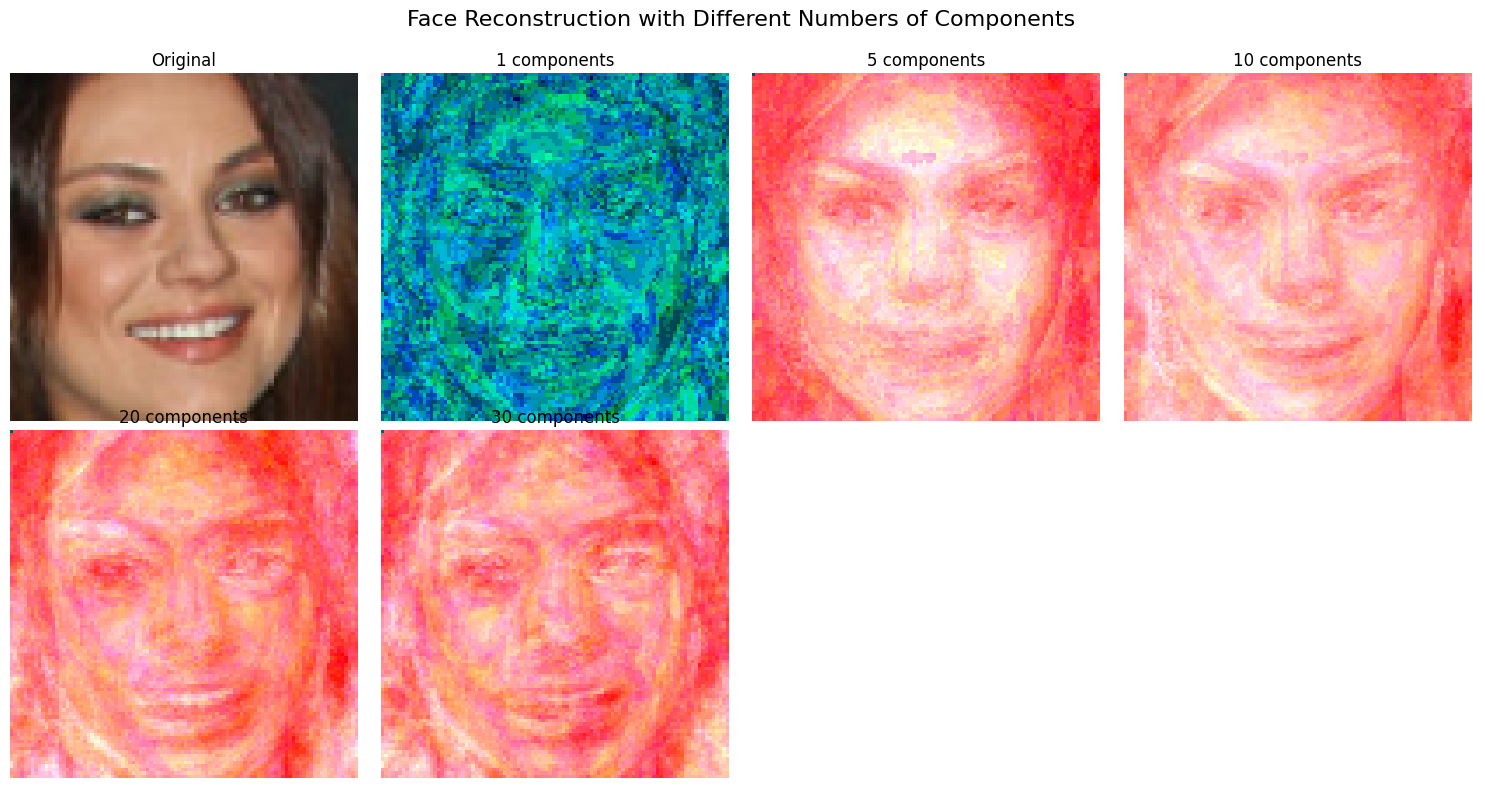

In [43]:
pca_feature_extractor = PCAFeatureExtractor(n_components=None)
pca_feature_extractor.fit(train_X)

pca_feature_extractor.plot_eigenfaces(n_eigenfaces=10)

sample_face_idx = 1
components = [1, 5, 10, 20, 30]
pca_feature_extractor.plot_face_reconstruction(train_X[sample_face_idx], components)

### 1.2.2. Feature Space Plots
...

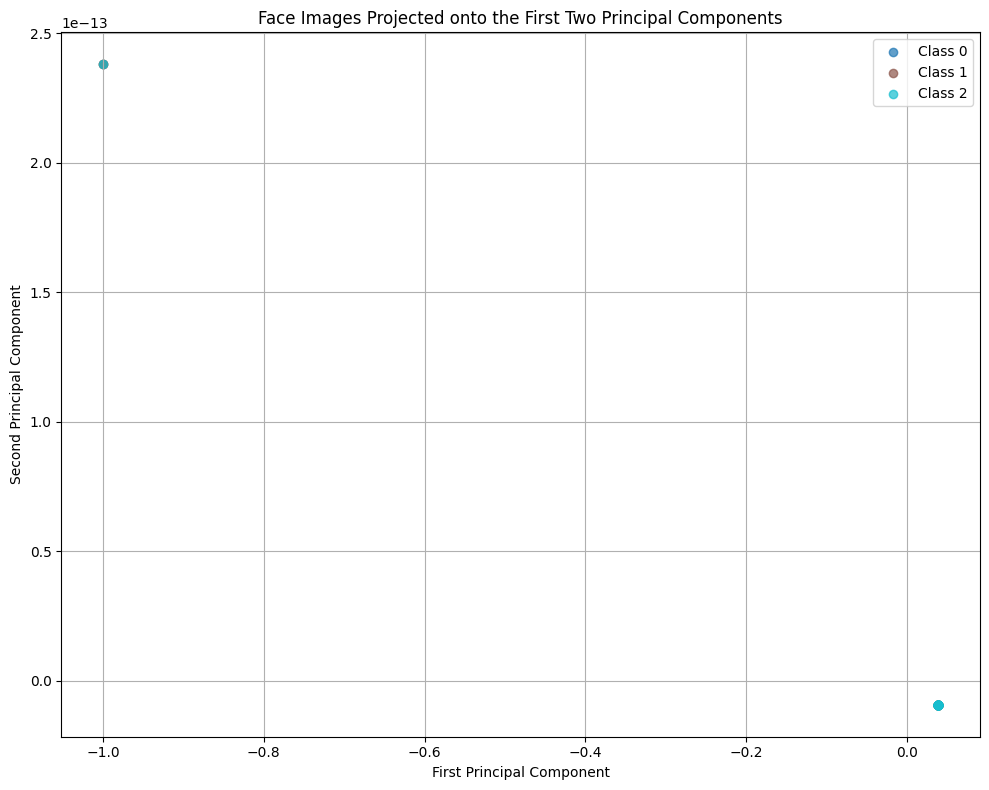

In [44]:
pca_feature_extractor.plot_feature_space(train_X, train_y)

### 1.2.3. Discussion

**Converting Images to a 2D Matrix**
For PCA, we need to represent each face image as a vector. If we have n face images, each with dimensions h×w (height × width), we create a data matrix X with dimensions n×(h×w).

**Dimensionality of Data Matrix**
Even though the dimensionality of each image vector (h×w) is high, the effective rank of the data matrix is at most min(n, h×w). Since we typically have fewer faces than pixels, the number of non-zero eigenvalues will be at most n-1.

**Mean Subtraction**
We center the data by subtracting the mean face: X̄ = X - μ, where μ is the mean face. This is important because PCA finds directions of maximum variance, and centering ensures that the first principal component corresponds to the direction of maximum variance.

**Eigenvalue vs. Singular Value Decomposition**
For PCA, we can use either approach:
- Eigendecomposition of the covariance matrix: C = X̄ᵀX̄/(n-1)
- SVD of the centered data matrix: X̄ = USVᵀ

When the dimensionality is high (h×w >> n), it's more efficient to compute the eigendecomposition of a smaller matrix: X̄X̄ᵀ/(n-1) = UΛUᵀ
This gives us the same eigenvectors as SVD but is more computationally efficient.

**Non-Zero Eigenvalues**
The maximum number of non-zero eigenvalues is min(n-1, h×w), where n is the number of face images and h×w is the dimensionality of each image. This explains why we typically get far fewer eigenvalues than dimensions.

**Optimal Number of Components**
We select the optimal number of principal components p based on the cumulative explained variance:
Σᵢ₌₁ᵖ λᵢ / Σᵢ₌₁ᵏ λᵢ ≥ threshold
where λᵢ are the eigenvalues and k is the total number of non-zero eigenvalues.

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [ ]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [ ]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier
...

In [ ]:
class FavoriteClassificationModel:
    """TODO: this classifier is under construction."""
    
    def fit(self, X, y):
        raise NotImplmentedError
        
    def predict(self, X):
        raise NotImplmentedError

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [ ]:
feature_extractor = IdentityFeatureExtractor() 
classifier = RandomClassificationModel()

# train the model on the features
classifier.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

In [ ]:
# evaluate performance of the model on the training set
train_y_star = model(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

In [ ]:
# predict the labels for the test set 
test_y_star = model(test_X)

# 5. Publishing best results

In [ ]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

In [ ]:
submission.to_csv('submission.csv')

# 6. Discussion
...

In summary we contributed the following: 
* 
